<a href="https://colab.research.google.com/github/jiwonojo/Data-Capstone-Design/blob/main/%EB%8D%B0%EC%BA%A1%EB%94%94_12_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers datasets accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 20.1 MB/s eta 0:00:00


In [ ]:
!pip install -q transformers

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW          # ← 수정된 부분
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from tqdm import tqdm

# =======================
# 1. 데이터 로드 & 분할
# =======================
df = pd.read_csv("/content/fake_reviews_dataset.csv")
print("데이터셋 shape:", df.shape)
print("컬럼:", df.columns.tolist())
print(df.head())

# y, X 분리
y = df["label"].values
texts = df["text"].astype(str).values

train_idx, test_idx = train_test_split(
    np.arange(len(df)),
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train_text = texts[train_idx]
y_train = y[train_idx]
X_test_text = texts[test_idx]
y_test = y[test_idx]

print("Train size:", len(X_train_text), "Test size:", len(X_test_text))

# =======================
# 2. 토크나이저 & Dataset 정의
# =======================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        # (batch 차원 1 제거)
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        # 일부 tokenizer는 token_type_ids가 있을 수도 있음
        if "token_type_ids" in enc:
            item["token_type_ids"] = enc["token_type_ids"].squeeze(0)
        return item

train_dataset = ReviewDataset(X_train_text, y_train, tokenizer)
test_dataset  = ReviewDataset(X_test_text, y_test, tokenizer)

print("train_dataset[0] keys:", train_dataset[0].keys())

# =======================
# 3. DataLoader 설정
# =======================
batch_size = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# =======================
# 4. 모델/옵티마이저 설정
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# =======================
# 5. 학습 + 평가 루프
# =======================
num_epochs = 2  # 필요하면 3까지 올려도 됨

for epoch in range(1, num_epochs+1):
    # ---- Train ----
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # ---- Eval ----
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch} - Evaluating"):
            labels = batch["labels"].numpy()
            all_labels.extend(labels)

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    preds = (all_probs >= 0.5).astype(int)

    f1 = f1_score(all_labels, preds)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = None

    print(f"\n=== Epoch {epoch} 결과 ===")
    print("Train Loss:", avg_train_loss)
    print("Test F1:", f1)
    print("Test AUC:", auc)

print("\n파인튜닝 완료!")

데이터셋 shape: (40526, 4)
컬럼: ['category', 'rating', 'text', 'label']
           category  rating  \
0  Home_and_Kitchen     5.0   
1  Home_and_Kitchen     5.0   
2  Home_and_Kitchen     5.0   
3  Home_and_Kitchen     1.0   
4  Home_and_Kitchen     5.0   

                                                text  label  
0  Love this!  Well made, sturdy, and very comfor...      1  
1  love it, a great upgrade from the original.  I...      1  
2  This pillow saved my back. I love the look and...      1  
3  Missing information on how to use it, but it i...      1  
4  Very nice set. Good quality. We have had the s...      1  
Train size: 28368 Test size: 12158
train_dataset[0] keys: dict_keys(['input_ids', 'attention_mask', 'labels', 'token_type_ids'])
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Evaluating: 100%|██████████| 760/760 [02:42<00:00,  4.67it/s]



=== Epoch 1 결과 ===
Train Loss: 0.11698768880370992
Test F1: 0.9644767302626327
Test AUC: 0.9969039480264198


Epoch 2 - Evaluating: 100%|██████████| 760/760 [02:42<00:00,  4.67it/s]



=== Epoch 2 결과 ===
Train Loss: 0.035222633093936216
Test F1: 0.9675511508951407
Test AUC: 0.9972594019184846

파인튜닝 완료!


데이터셋 shape: (40526, 4)
컬럼: ['category', 'rating', 'text', 'label']
           category  rating  \
0  Home_and_Kitchen     5.0   
1  Home_and_Kitchen     5.0   
2  Home_and_Kitchen     5.0   
3  Home_and_Kitchen     1.0   
4  Home_and_Kitchen     5.0   

                                                text  label  
0  Love this!  Well made, sturdy, and very comfor...      1  
1  love it, a great upgrade from the original.  I...      1  
2  This pillow saved my back. I love the look and...      1  
3  Missing information on how to use it, but it i...      1  
4  Very nice set. Good quality. We have had the s...      1  
Train size: 28368 Test size: 12158
train_dataset[0] keys: dict_keys(['input_ids', 'attention_mask', 'labels', 'token_type_ids'])
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Evaluating: 100%|██████████| 760/760 [02:36<00:00,  4.87it/s]



=== Epoch 1 결과 ===
Train Loss: 0.23829459989505405
Val Loss  : 1.0467021592218724
Val F1    : 0.8052292786515363
Val AUC   : 0.9710805901148883


Epoch 2 - Evaluating: 100%|██████████| 760/760 [02:36<00:00,  4.86it/s]



=== Epoch 2 결과 ===
Train Loss: 0.08512683308867053
Val Loss  : 1.2382081423045173
Val F1    : 0.8185927275180462
Val AUC   : 0.9538841229241849


Epoch 3 - Evaluating: 100%|██████████| 760/760 [02:36<00:00,  4.87it/s]



=== Epoch 3 결과 ===
Train Loss: 0.053797906958271205
Val Loss  : 1.076885541982598
Val F1    : 0.8543293240486741
Val AUC   : 0.9821973087738972


Epoch 4 - Evaluating: 100%|██████████| 760/760 [02:36<00:00,  4.86it/s]



=== Epoch 4 결과 ===
Train Loss: 0.02857811714898354
Val Loss  : 1.6173632221187242
Val F1    : 0.8323517326393645
Val AUC   : 0.9698770449659794


Epoch 5 - Evaluating: 100%|██████████| 760/760 [02:36<00:00,  4.85it/s]



=== Epoch 5 결과 ===
Train Loss: 0.016244596343487287
Val Loss  : 2.0410125951138407
Val F1    : 0.8133279807306303
Val AUC   : 0.9536689509381352

Early stopping 발동 (patience=2)

파인튜닝 완료!


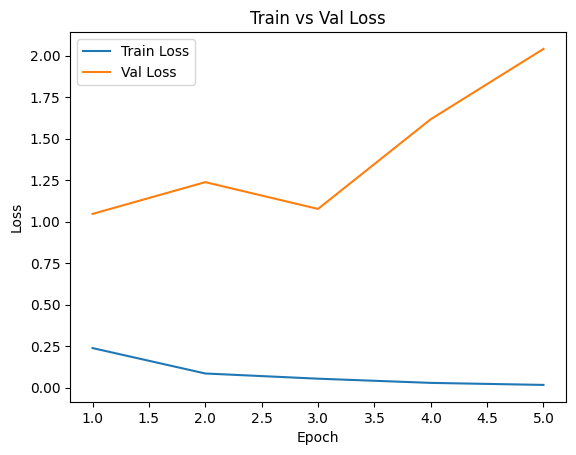

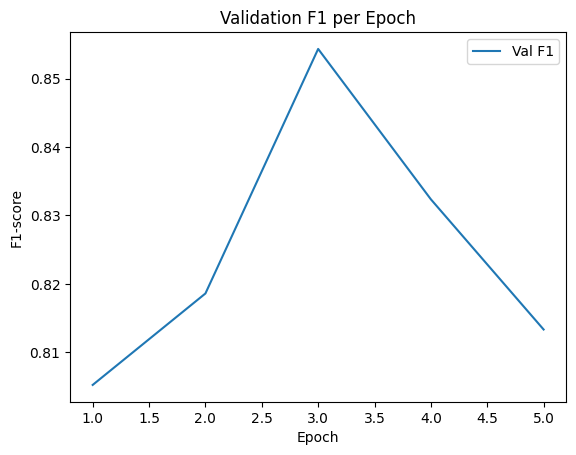

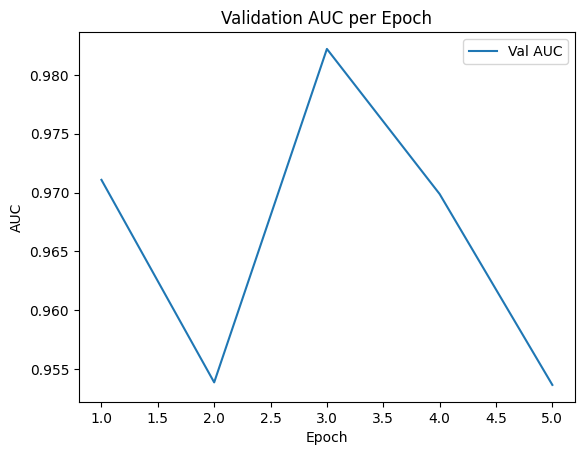

In [ ]:
# =======================
# 0. 설치 & 기본 라이브러리
# =======================
!pip install -q transformers

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# =======================
# 1. 데이터 로드 & 분할
# =======================
df = pd.read_csv("/content/fake_reviews_dataset.csv")
print("데이터셋 shape:", df.shape)
print("컬럼:", df.columns.tolist())
print(df.head())

# y, X 분리
y = df["label"].values
texts = df["text"].astype(str).values

train_idx, test_idx = train_test_split(
    np.arange(len(df)),
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train_text = texts[train_idx]
y_train = y[train_idx]
X_test_text = texts[test_idx]
y_test = y[test_idx]

print("Train size:", len(X_train_text), "Test size:", len(X_test_text))

# =======================
# 2. 토크나이저 & Dataset 정의
# =======================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        if "token_type_ids" in enc:
            item["token_type_ids"] = enc["token_type_ids"].squeeze(0)
        return item

train_dataset = ReviewDataset(X_train_text, y_train, tokenizer)
test_dataset  = ReviewDataset(X_test_text, y_test, tokenizer)

print("train_dataset[0] keys:", train_dataset[0].keys())

# =======================
# 3. DataLoader 설정
# =======================
batch_size = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# =======================
# 4. 모델/옵티마이저/스케줄러 설정
#    - Dropout 강화
#    - weight_decay
#    - scheduler (linear warmup & decay)
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dropout 조금 더 키운 config + num_labels 설정
config = AutoConfig.from_pretrained(model_name)
config.hidden_dropout_prob = 0.3                # default: 0.1
config.attention_probs_dropout_prob = 0.1       # default 그대로 or 살짝 조정
config.num_labels = 2                           # 여기에 클래스 수 설정

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config        # ⚠ num_labels는 여기서 넘기지 않음
).to(device)

# weight_decay 추가 (L2 정규화)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# 에폭 수는 넉넉히 두고, early stopping으로 자르기
num_epochs = 5

num_training_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# =======================
# 5. 학습 + 평가 루프
#    - gradient clipping
#    - early stopping (F1 기준)
#    - 로그 기록 (Train/Val Loss, F1, AUC)
# =======================
train_losses = []
val_losses = []
val_f1s = []
val_aucs = []

best_val_f1 = 0.0
patience = 2   # 성능이 안 좋아지는 에폭 수 허용
no_improve_cnt = 0

for epoch in range(1, num_epochs+1):
    # ---- Train ----
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch} - Evaluating"):
            # label은 CPU numpy로 따로 빼두고
            labels = batch["labels"].numpy()
            all_labels.extend(labels)

            # 모델 입력은 GPU로
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)

    avg_val_loss = val_loss / len(test_loader)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    preds = (all_probs >= 0.5).astype(int)

    f1 = f1_score(all_labels, preds)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = None

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_f1s.append(f1)
    val_aucs.append(auc if auc is not None else np.nan)

    print(f"\n=== Epoch {epoch} 결과 ===")
    print("Train Loss:", avg_train_loss)
    print("Val Loss  :", avg_val_loss)
    print("Val F1    :", f1)
    print("Val AUC   :", auc)

    # ---- Early Stopping ----
    if f1 > best_val_f1:
        best_val_f1 = f1
        no_improve_cnt = 0
        # 필요하면 best 모델 저장
        # torch.save(model.state_dict(), "best_bert_fake_review.pt")
    else:
        no_improve_cnt += 1
        if no_improve_cnt >= patience:
            print(f"\nEarly stopping 발동 (patience={patience})")
            break

print("\n파인튜닝 완료!")

# =======================
# 6. Loss / Metric 그래프 그리기
# =======================
epochs_range = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, val_f1s, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("Validation F1 per Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, val_aucs, label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Validation AUC per Epoch")
plt.legend()
plt.show()

In [ ]:
# ==============================================
# 0. 설치
# ==============================================
!pip install lightgbm -q

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier

# ==============================================
# 1. 데이터 로드
# ==============================================
df = pd.read_csv("/content/fake_reviews_dataset.csv")
print(df.head())

texts = df["text"].astype(str)
labels = df["label"].astype(int)

# ==============================================
# 2. Train/Test Split
# ==============================================
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)

# ==============================================
# 3. Text → TF-IDF 변환
# ==============================================
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=3
)

X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

# ==============================================
# 4. LGBM 학습
# ==============================================
lgbm = LGBMClassifier(
    n_estimators=300,
    max_depth=-1,
    learning_rate=0.05,
    objective="binary",
    num_leaves=64,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)
pred_proba = lgbm.predict_proba(X_test)[:,1]
pred = (pred_proba >= 0.5).astype(int)

print("=== Classification Report ===")
print(classification_report(y_test, pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, pred))

# ==============================================
# 5. 오분류 샘플 추출
# ==============================================
test_df = pd.DataFrame({
    "text": X_test_text,
    "label": y_test.values,
    "pred": pred,
    "proba": pred_proba
})

# FN = 실제 1인데 0으로 분류 (진짜 리뷰인데 가짜라 판단)
fn = test_df[(test_df["label"] == 1) & (test_df["pred"] == 0)]

# FP = 실제 0인데 1로 분류 (가짜 리뷰 아닌데 가짜라고 판단)
fp = test_df[(test_df["label"] == 0) & (test_df["pred"] == 1)]

print("\nFalse Negative 개수:", len(fn))
print("False Positive 개수:", len(fp))

# ==============================================
# 6. 오분류 텍스트 간단 탐색
# ==============================================

# 가장 확신하고 틀린 샘플 (confidence 높은데 잘못 예측)
print("\n=== FN 중 모델이 강하게 잘못 예측한 상위 5개 ===")
display(fn.sort_values("proba", ascending=True).head())

print("\n=== FP 중 모델이 강하게 잘못 예측한 상위 5개 ===")
display(fp.sort_values("proba", ascending=False).head())

# ==============================================
# 7. 오분류 텍스트 특징 분석 (길이, 감성 등)
# ==============================================

# 텍스트 길이 feature
test_df["length"] = test_df["text"].apply(lambda x: len(x.split()))

print("\n=== 평균 텍스트 길이 비교 ===")
print(test_df.groupby(["label","pred"])["length"].mean())

# 감성 점수
from textblob import TextBlob
test_df["polarity"] = test_df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

print("\n=== 평균 감성 점수 비교 ===")
print(test_df.groupby(["label","pred"])["polarity"].mean())

# ==============================================
# 8. TF-IDF 기반으로 어떤 단어가 오분류에 많이 나타났는지 분석
# ==============================================

def top_terms(doc_indices, vectorizer, X_matrix, topn=30):
    """doc_indices: 문서 인덱스 리스트"""
    subset = X_matrix[doc_indices]
    mean_tfidf = np.array(subset.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[::-1][:topn]
    terms = np.array(vectorizer.get_feature_names_out())
    return list(zip(terms[top_indices], mean_tfidf[top_indices]))

# FN 문서 index
fn_idx = fn.index.tolist()
fp_idx = fp.index.tolist()

print("\n=== FN에서 많이 나오는 단어 TOP 20 ===")
print(top_terms(fn_idx, tfidf, X_test, topn=20))

print("\n=== FP에서 많이 나오는 단어 TOP 20 ===")
print(top_terms(fp_idx, tfidf, X_test, topn=20))


           category  rating  \
0  Home_and_Kitchen     5.0   
1  Home_and_Kitchen     5.0   
2  Home_and_Kitchen     5.0   
3  Home_and_Kitchen     1.0   
4  Home_and_Kitchen     5.0   

                                                text  label  
0  Love this!  Well made, sturdy, and very comfor...      1  
1  love it, a great upgrade from the original.  I...      1  
2  This pillow saved my back. I love the look and...      1  
3  Missing information on how to use it, but it i...      1  
4  Very nice set. Good quality. We have had the s...      1  
[LightGBM] [Info] Number of positive: 14206, number of negative: 14162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.814593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 466302
[LightGBM] [Info] Number of data points in the train set: 28368, number of used features: 13216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500776 -> initscore=0.0031

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      6070
           1       0.94      0.92      0.93      6088

    accuracy                           0.93     12158
   macro avg       0.93      0.93      0.93     12158
weighted avg       0.93      0.93      0.93     12158

=== Confusion Matrix ===
[[5693  377]
 [ 491 5597]]

False Negative 개수: 491
False Positive 개수: 377

=== FN 중 모델이 강하게 잘못 예측한 상위 5개 ===


,text,label,pred,proba
36957,Absolutely adorable! I can't wait to wear them...,1,0,0.022126
36837,"I like them, though they're a little short. I...",1,0,0.027730
4807,"It's perfect, covers my beach time perfectly, ...",1,0,0.028138
683,Really great iron...my only thing is it doesn'...,1,0,0.030244
8002,Easy to install even without a power supply. ...,1,0,0.031308



=== FP 중 모델이 강하게 잘못 예측한 상위 5개 ===


,text,label,pred,proba
37354,"My oldest son is a bit sarcastic, He loves thi...",0,1,0.988848
28918,Got this for my daughters schooling and we als...,0,1,0.987787
40438,This novel is a masterpiece. The plot is gripp...,0,1,0.982886
16774,I've ordered a couple of different type of wir...,0,1,0.982099
295,Is s good strong suction vacuume. World's good...,0,1,0.981034



=== 평균 텍스트 길이 비교 ===
label  pred
0      0       77.231688
       1       29.625995
1      0       36.482688
       1       64.360193
Name: length, dtype: float64

=== 평균 감성 점수 비교 ===
label  pred
0      0       0.244763
       1       0.312343
1      0       0.266523
       1       0.281567
Name: polarity, dtype: float64

=== FN에서 많이 나오는 단어 TOP 20 ===


IndexError: index (40486) out of range